# U-Net模型复现

## 初始所需库

In [2]:
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

## 获取训练数据集

In [3]:
def read_tiff_file(file_path: str) -> Optional[np.ndarray]:
    """
    Reads a TIFF file and returns its content as a NumPy array.

    Args:
        file_path (str): The path to the TIFF file.

    Returns:
        Optional[np.ndarray]: The image data from the TIFF file.
                               Returns None if the file is not found or is not a TIFF file.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None
    if not file_path.lower().endswith(('.tif', '.tiff')):
        print(f"Error: {file_path} is not a TIFF file.")
        return None
    try:
        image: np.ndarray = tifffile.imread(file_path)
        print(f"Successfully read {file_path}")
        return image
    except Exception as e:
        print(f"Error reading TIFF file {file_path}: {e}")
        return None

data_directory: str = "d:\\PythonProject\\Computational_Pathology\\data"
train_image_file_name: str = "train-volume.tif"
train_label_file_name: str = "train-labels.tif"

train_image_path: str = os.path.join(data_directory, train_image_file_name)
train_label_path: str = os.path.join(data_directory, train_label_file_name)

train_image_data: Optional[np.ndarray] = read_tiff_file(train_image_path)
train_label_data: Optional[np.ndarray] = read_tiff_file(train_label_path)

Successfully read d:\PythonProject\Computational_Pathology\data\train-volume.tif
Successfully read d:\PythonProject\Computational_Pathology\data\train-labels.tif


## 观察数据集中的一张图片

Train image data shape: (30, 512, 512)
Train label data shape: (30, 512, 512)
Displaying slice 2 from train image (assuming stack is axis 0).
Displaying slice 2 from train label (assuming stack is axis 0).


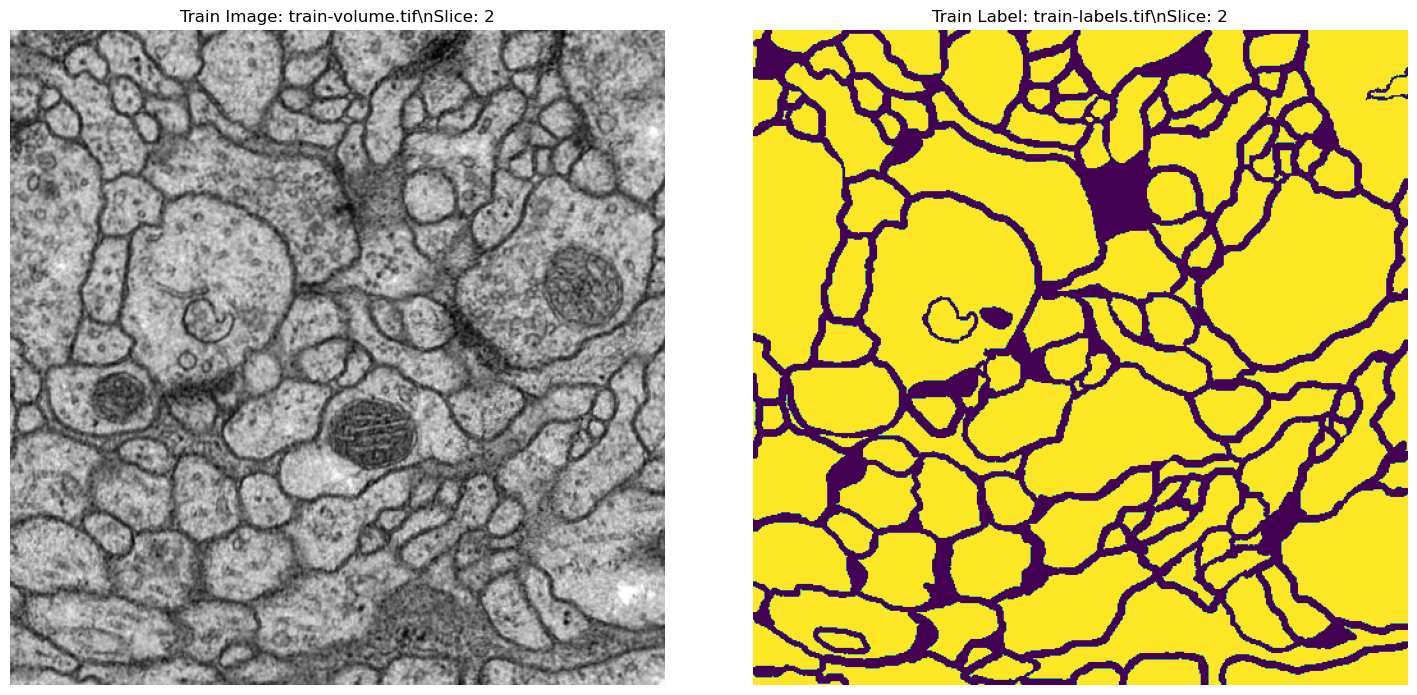

In [4]:
# Ensure this index is valid for both your image and label stacks
slice_index: int = 2

if train_image_data is not None and train_label_data is not None:
    print(f"Train image data shape: {train_image_data.shape}")
    print(f"Train label data shape: {train_label_data.shape}")

    display_image_slice: Optional[np.ndarray] = None
    display_label_slice: Optional[np.ndarray] = None
    
    # Prepare image slice
    if train_image_data.ndim == 3: # Assuming (Depth, Height, Width) or (Height, Width, Depth)
        # Try to determine stack dimension. Common is (D, H, W) or (H, W, D)
        # This logic assumes if one dimension is much smaller than others and >1, it's the stack dim.
        # For simplicity, let's assume if shape[0] is the stack dimension for now.
        # A more robust check might be needed based on typical stack dimensions.
        if slice_index < train_image_data.shape[0]:
            display_image_slice = train_image_data[slice_index, :, :]
            print(f"Displaying slice {slice_index} from train image (assuming stack is axis 0).")
        elif slice_index < train_image_data.shape[2] and train_image_data.shape[2] < train_image_data.shape[0] and train_image_data.shape[2] < train_image_data.shape[1]: # (H, W, D)
             display_image_slice = train_image_data[:, :, slice_index]
             print(f"Displaying slice {slice_index} from train image (assuming stack is axis 2).")
        else:
            print(f"Warning: Slice index {slice_index} might be out of bounds for train image stack or stack dimension unclear. Attempting default.")
            # Fallback or error
            if train_image_data.shape[0] > 1: display_image_slice = train_image_data[0, :, :] # Default to first slice
            else: print("Cannot determine slice for train image.")

    elif train_image_data.ndim == 2:
        display_image_slice = train_image_data
        print("Train image is 2D, displaying as is.")
    else:
        print(f"Train image has unsupported dimension: {train_image_data.ndim}")

    # Prepare label slice (assuming similar stacking as image)
    if train_label_data.ndim == 3:
        if slice_index < train_label_data.shape[0]:
            display_label_slice = train_label_data[slice_index, :, :]
            print(f"Displaying slice {slice_index} from train label (assuming stack is axis 0).")
        elif slice_index < train_label_data.shape[2] and train_label_data.shape[2] < train_label_data.shape[0] and train_label_data.shape[2] < train_label_data.shape[1]:
             display_label_slice = train_label_data[:, :, slice_index]
             print(f"Displaying slice {slice_index} from train label (assuming stack is axis 2).")
        else:
            print(f"Warning: Slice index {slice_index} might be out of bounds for train label stack or stack dimension unclear. Attempting default.")
            if train_label_data.shape[0] > 1: display_label_slice = train_label_data[0, :, :]
            else: print("Cannot determine slice for train label.")
            
    elif train_label_data.ndim == 2:
        display_label_slice = train_label_data
        print("Train label is 2D, displaying as is.")
    else:
        print(f"Train label has unsupported dimension: {train_label_data.ndim}")

    # Check if slices were successfully prepared
    if display_image_slice is not None and display_label_slice is not None:
        # Ensure shapes are compatible for display, or handle mismatch
        if display_image_slice.shape != display_label_slice.shape:
            print(f"Warning: Image slice shape {display_image_slice.shape} and label slice shape {display_label_slice.shape} do not match.")
            # Basic resize attempt if they are 2D, this is a simple approach and might not be ideal for all cases
            if display_image_slice.ndim == 2 and display_label_slice.ndim == 2:
                # Example: Resize label to image. For actual tasks, more careful registration/resampling is needed.
                # This requires libraries like scikit-image or OpenCV. For now, we'll just warn.
                print("Displaying with potentially misaligned shapes. Consider resizing/registration.")


        fig, axes = plt.subplots(1, 2, figsize=(15, 7)) # Adjusted figsize
        
        # Display image slice
        axes[0].imshow(display_image_slice, cmap='gray') # 'gray' is common for medical images
        title_img: str = f"Train Image: {train_image_file_name}\\nSlice: {slice_index}"
        axes[0].set_title(title_img)
        axes[0].axis('off')

        # Display label slice
        # Choose a colormap appropriate for your labels (e.g., 'viridis', 'jet', or a custom map if categorical)
        axes[1].imshow(display_label_slice, cmap='viridis') 
        title_lbl: str = f"Train Label: {train_label_file_name}\\nSlice: {slice_index}"
        axes[1].set_title(title_lbl)
        axes[1].axis('off')

        plt.tight_layout() # Adjusts subplot params for a tight layout.
        plt.show()
    else:
        if display_image_slice is None:
            print("Failed to prepare image slice for display.")
        if display_label_slice is None:
            print("Failed to prepare label slice for display.")

elif train_image_data is None:
    print(f"Failed to read training image data from {train_image_path}.")
elif train_label_data is None:
    print(f"Failed to read training label data from {train_label_path}.")


## 数据预处理
### 引入训练模型与处理数据所需库

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from U_Net import UNet, UNetTrainer
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.model_selection import KFold

c:\Users\cswzq\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\cswzq\anaconda3\envs\ML\lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


### 数据增强

In [6]:
# --- Define Augmentation Pipeline ---
# Parameters for ElasticTransform are chosen to be illustrative.
# The U-Net paper mentions: "3x3 coarse grid", "random displacement vectors ... from a Gaussian distribution with a standard deviation of 10 pixels".
# Fine-tuning these parameters in ElasticTransform (alpha, sigma, alpha_affine) might be needed to match the paper's effect precisely.
# alpha: intensity of displacement. sigma: smoothness. alpha_affine: intensity of affine part.
# For border_mode, use BORDER_CONSTANT with value 0 (black) as implied for segmentation.

# Training augmentations
train_transform = A.Compose([
    A.ElasticTransform(
        p=0.7, alpha=120, sigma=120 * 0.07, alpha_affine=120 * 0.03, # Example values, tune these
        interpolation=cv2.INTER_CUBIC, # Bicubic interpolation as per paper
        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0
    ),
    A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.ShiftScaleRotate(
        shift_limit=0.08, scale_limit=0.1, rotate_limit=0, # Rotation handled by A.Rotate
        p=0.5, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0
    ),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    # Normalization should happen after geometric and intensity augmentations
    # The original preprocess_and_pad_images did min-max normalization.
    # We will do it per-image here after augmentation.
    # A.Normalize(mean=(0.5,), std=(0.5,)), # Example if using fixed mean/std
    ToTensorV2() # Converts image and mask to PyTorch tensors
])

# Validation augmentations (usually minimal: just normalization and tensor conversion)
val_transform = A.Compose([
    # A.Normalize(mean=(0.5,), std=(0.5,)), # Example
    ToTensorV2()
])

# --- Custom Dataset for ISBI 2012 with Augmentations ---
class ISBI2012AugmentedDataset(Dataset):
    def __init__(self, images_np: np.ndarray, masks_np: np.ndarray, transform=None, target_size=(512,512)):
        """
        Args:
            images_np (np.ndarray): Full stack of images (N, H, W), dtype uint8 or similar.
            masks_np (np.ndarray): Full stack of masks (N, H, W), dtype uint8 or similar (0 or 255).
            transform (albumentations.Compose): Augmentation pipeline.
            target_size (tuple): Desired (H, W) for the output tensors. Images will be padded if smaller.
                                 Since ISBI is 512x512, and we want 512x512, padding is mostly for safety
                                 or if augmentations change size slightly and we need to restore it.
        """
        self.images = images_np
        self.masks = masks_np
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape (H, W)
        mask = self.masks[idx]    # Shape (H, W)

        # Ensure mask is binary 0 or 1 before augmentation
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image_aug = augmented['image'] # This will be (C, H, W) if ToTensorV2 is used
            mask_aug = augmented['mask']   # This will be (C, H, W) or (H, W)
        else: # Should not happen for training, but as a fallback
            image_aug = torch.from_numpy(image[np.newaxis, ...]).float() # Add channel, convert
            mask_aug = torch.from_numpy(mask[np.newaxis, ...]).float()

        # Normalize image to [0, 1] after augmentation (if not done by A.Normalize)
        # ToTensorV2 by default scales images with dtype uint8 to [0,1]
        # If input to ToTensorV2 is float, it's not scaled. Our 'image' is uint8.
        # If A.Normalize is used, this step might be redundant or conflict.
        # Let's assume ToTensorV2 handles uint8 -> [0,1] float tensor.

        # Ensure mask is (1, H, W) and float
        if mask_aug.ndim == 2: # If ToTensorV2 makes it (H,W)
            mask_aug = mask_aug.unsqueeze(0)
        
        # Pad if necessary to target_size (e.g., if augmentations slightly changed size)
        # This is a simplified padding. A.PadIfNeeded in the pipeline is better.
        # For now, assuming augmentations are configured to mostly preserve 512x512 or
        # that slight deviations are acceptable / handled by network.
        # If strict 512x512 is needed, A.PadIfNeeded(min_height=512, min_width=512, border_mode=...)
        # should be the last step in the augmentation pipeline.

        return image_aug, mask_aug.float() # Ensure mask is float for BCE/Dice loss

print("Augmentation pipeline and ISBI2012AugmentedDataset defined.")

Augmentation pipeline and ISBI2012AugmentedDataset defined.


C:\Users\cswzq\AppData\Local\Temp\ipykernel_3488\3926576521.py:10: UserWarning: Argument(s) 'alpha_affine, value, mask_value' are not valid for transform ElasticTransform
  A.ElasticTransform(
C:\Users\cswzq\AppData\Local\Temp\ipykernel_3488\3926576521.py:15: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
c:\Users\cswzq\anaconda3\envs\ML\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\cswzq\AppData\Local\Temp\ipykernel_3488\3926576521.py:16: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


### 扩展通道维度

In [7]:
def preprocess_and_pad_images(imgs: np.ndarray, target_size: tuple = (512, 512)) -> Optional[torch.Tensor]: # MODIFIED target_size default
    """
    Preprocesses raw image data for U-Net input, including padding if necessary.
    Images are normalized to [0,1].
    Labels (if passed through this function) should be handled carefully regarding normalization if they are not binary.

    Args:
        imgs: NumPy array of shape (N, H, W), dtype could be uint8/uint16/float32...
              Represents a stack of N images, each with height H and width W.
        target_size: Tuple (target_H, target_W) for padding.

    Returns:
        A PyTorch tensor of shape (N, target_H, target_W, 1), dtype float32, 
        with values normalized to [0,1] and padded.
        Returns None if input imgs is None.
    """
    # 0. Check if imgs is None
    if imgs is None:
        print("Warning: Input images (imgs) to preprocess_and_pad_images is None. Returning None.")
        return None

    # 1. 扩展通道： (N, H, W) -> (N, H, W, 1)
    imgs_expanded = imgs[..., np.newaxis]

    # 2. 转成 float32
    imgs_float32 = imgs_expanded.astype(np.float32)

    # 3. 全局线性归一化到 [0,1]
    min_val = np.min(imgs_float32)
    max_val = np.max(imgs_float32)
    
    if max_val == min_val:
        # Handle cases where all pixel values are the same (e.g., completely black or white image)
        # If min_val is 0, normalized is 0. If min_val is 1 (for binary), normalized is 1.
        # Or, more generally, if all values are C, then (C-C)/(C-C+eps) = 0.
        # For binary masks that are already 0 or 1, this normalization maintains them.
        imgs_normalized = np.zeros_like(imgs_float32) if min_val == 0 else imgs_float32 / (min_val + 1e-8) # Avoid division by zero if max_val is also 0
        if min_val != 0 and min_val != 1: # if it's not already normalized binary
             imgs_normalized = (imgs_float32 - min_val) / (max_val - min_val + 1e-8) # fallback to original if uniform non-binary
        elif max_val == min_val and max_val != 0 : # e.g. all 255
             imgs_normalized = imgs_float32 / max_val


    else:
        imgs_normalized = (imgs_float32 - min_val) / (max_val - min_val + 1e-8)

    # 4. Pad to target_size if necessary
    current_h, current_w = imgs_normalized.shape[1], imgs_normalized.shape[2]
    target_h, target_w = target_size

    pad_h = target_h - current_h
    pad_w = target_w - current_w

    imgs_padded = imgs_normalized # Default to no padding

    if pad_h < 0 or pad_w < 0:
        print(f"Warning: Target size {target_size} is smaller than current size ({current_h}, {current_w}). Cropping or resizing might be needed. Returning unpadded but normalized tensor.")
        # Consider implementing cropping or resizing here if this scenario is expected.
        # For ISBI 512x512 and target 512x512, this block should not be hit.
    elif pad_h == 0 and pad_w == 0:
        print(f"Images are already at target size ({current_h},{current_w}). No padding needed.")
    else: # pad_h > 0 or pad_w > 0
        pad_h_before = pad_h // 2
        pad_h_after = pad_h - pad_h_before
        pad_w_before = pad_w // 2
        pad_w_after = pad_w - pad_w_before

        padding_config = (
            (0, 0),  # No padding for N dimension
            (pad_h_before, pad_h_after),  # Padding for H dimension
            (pad_w_before, pad_w_after),  # Padding for W dimension
            (0, 0)   # No padding for C dimension
        )
        # Pad with 0, which is appropriate for normalized images [0,1]
        imgs_padded = np.pad(imgs_normalized, pad_width=padding_config, mode='constant', constant_values=0)
        print(f"Padded images from ({current_h},{current_w}) to ({imgs_padded.shape[1]},{imgs_padded.shape[2]})")

    # 5. 转成 PyTorch tensor
    return torch.from_numpy(imgs_padded).float()

# --- Main part of the cell ---
# This part assumes 'train_image_data' and 'train_label_data' are loaded in a previous cell.

TARGET_IMG_SIZE = (512, 512) # MODIFIED HERE

# Initialize processed variables to None
train_images_proc = None
train_labels_proc = None

# 预处理图像 (Preprocess images)
if 'train_image_data' in locals() and train_image_data is not None:
    print(f"Original train_image_data shape: {train_image_data.shape}, dtype: {train_image_data.dtype}")
    train_images_proc = preprocess_and_pad_images(train_image_data, target_size=TARGET_IMG_SIZE)
    if train_images_proc is not None:
        print(f"Processed train_images_proc shape: {train_images_proc.shape}, dtype: {train_images_proc.dtype}")
else:
    print("Warning: 'train_image_data' is not defined or is None. Skipping image preprocessing.")

# 预处理标签 (Preprocess labels)
# For labels, we want them to be binary (0 or 1) and then padded if necessary.
if 'train_label_data' in locals() and train_label_data is not None:
    print(f"Original train_label_data shape: {train_label_data.shape}, dtype: {train_label_data.dtype}")
    
    # 1. Binarize labels to 0 or 1. ISBI labels are 0 or 255.
    labels_binary = (train_label_data > 127).astype(np.float32) # Results in 0.0 or 1.0

    # 2. 扩展通道 (N, H, W) -> (N, H, W, 1)
    labels_expanded = labels_binary[..., np.newaxis]
    
    # 3. Pad labels to target_size if necessary
    current_h_label, current_w_label = labels_expanded.shape[1], labels_expanded.shape[2]
    target_h_label, target_w_label = TARGET_IMG_SIZE
    
    pad_h_label = target_h_label - current_h_label
    pad_w_label = target_w_label - current_w_label
    
    labels_padded = labels_expanded # Default to no padding

    if pad_h_label < 0 or pad_w_label < 0:
        print(f"Warning: Target size {TARGET_IMG_SIZE} for labels is smaller than current size ({current_h_label}, {current_w_label}). Cropping or resizing might be needed. Labels will not be padded.")
    elif pad_h_label == 0 and pad_w_label == 0:
        print(f"Labels are already at target size ({current_h_label},{current_w_label}). No padding needed.")
    else: # pad_h_label > 0 or pad_w_label > 0
        pad_h_label_before = pad_h_label // 2
        pad_h_label_after = pad_h_label - pad_h_label_before
        pad_w_label_before = pad_w_label // 2
        pad_w_label_after = pad_w_label - pad_w_label_before

        padding_config_label = (
            (0, 0),
            (pad_h_label_before, pad_h_label_after),
            (pad_w_label_before, pad_w_label_after),
            (0, 0)
        )
        # Pad binary labels with 0
        labels_padded = np.pad(labels_expanded, pad_width=padding_config_label, mode='constant', constant_values=0)
        print(f"Padded labels from ({current_h_label},{current_w_label}) to ({labels_padded.shape[1]},{labels_padded.shape[2]})")

    # 4. Convert to PyTorch tensor
    train_labels_proc = torch.from_numpy(labels_padded).float() # Ensure float for BCEWithLogitsLoss/Dice
    print(f"Processed train_labels_proc shape: {train_labels_proc.shape}, dtype: {train_labels_proc.dtype}")
else:
    print("Warning: 'train_label_data' is not defined or is None. Skipping label preprocessing.")

# Print final shapes if processing was successful
if train_images_proc is not None:
    print(f"Final train_images_proc shape: {train_images_proc.shape}") # Expected: (30, 512, 512, 1)
else:
    print("train_images_proc remains None.")

if train_labels_proc is not None:
    print(f"Final train_labels_proc shape: {train_labels_proc.shape}") # Expected: (30, 512, 512, 1)
else:
    print("train_labels_proc remains None.")

Original train_image_data shape: (30, 512, 512), dtype: uint8
Images are already at target size (512,512). No padding needed.
Processed train_images_proc shape: torch.Size([30, 512, 512, 1]), dtype: torch.float32
Original train_label_data shape: (30, 512, 512), dtype: uint8
Labels are already at target size (512,512). No padding needed.
Processed train_labels_proc shape: torch.Size([30, 512, 512, 1]), dtype: torch.float32
Final train_images_proc shape: torch.Size([30, 512, 512, 1])
Final train_labels_proc shape: torch.Size([30, 512, 512, 1])


### 载入训练模型

In [14]:
# --- K-Fold Cross-Validation & Training Setup ---
# Hyperparameters
K_FOLDS = 5
EPOCHS = 50  # Set a higher number; early stopping will find the best epoch
BATCH_SIZE = 2
LEARNING_RATE = 1e-4 # A good starting point for Adam with U-Net

# --- ADDED THIS LINE TO FIX THE ERROR ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
# -----------------------------------------

# Ensure the 'models' directory exists
os.makedirs('./models', exist_ok=True)

# Use the raw numpy arrays loaded earlier (e.g., from the .tif files)
# This assumes they are named 'train_image_data' and 'train_label_data'
images_np = train_image_data
masks_np = train_label_data

# 1. Initialize KFold for cross-validation
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# 2. List to store the best validation Dice score from each fold
fold_results = []

# 3. Start the cross-validation loop
print(f"Starting {K_FOLDS}-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(images_np)):
    print(f"\n{'='*20} FOLD {fold + 1}/{K_FOLDS} {'='*20}")

    # Create instances of the augmented dataset for training and validation sets
    train_dataset_fold = ISBI2012AugmentedDataset(
        images_np=images_np[train_idx],
        masks_np=masks_np[train_idx],
        transform=train_transform
    )
    val_dataset_fold = ISBI2012AugmentedDataset(
        images_np=images_np[val_idx],
        masks_np=masks_np[val_idx],
        transform=val_transform
    )

    # Create DataLoaders for the current fold
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    print(f"Train set size: {len(train_dataset_fold)} images | Validation set size: {len(val_dataset_fold)} images")

    # IMPORTANT: Re-initialize the model and trainer for each fold
    print("Initializing a new U-Net model and trainer for this fold...")
    model = UNet(n_channels=1, n_classes=1).to(DEVICE)
    trainer = UNetTrainer(model=model, device=DEVICE, lr=LEARNING_RATE)

    # Define a unique path to save the model for this specific fold
    model_save_path_fold = f'./models/unet_isbi_fold_{fold + 1}_best.pth'

    # --- Start Training for the Fold ---
    trainer.train(
        train_loader=train_loader_fold,
        val_loader=val_loader_fold,
        epochs=EPOCHS,
        model_save_path=model_save_path_fold
    )

    # After training, store the best validation Dice score achieved in this fold
    best_dice_for_fold = trainer.best_val_dice
    fold_results.append(best_dice_for_fold)
    print(f"--- Fold {fold + 1} Finished. Best Validation Dice: {best_dice_for_fold:.4f} ---")


# --- Final Results ---
average_dice = np.mean(fold_results)
std_dice = np.std(fold_results)

print(f"\n{'='*20} K-Fold Cross-Validation Summary {'='*20}")
print(f"Validation Dice scores for each fold: {[f'{d:.4f}' for d in fold_results]}")
print(f"Average Validation Dice over {K_FOLDS} folds: {average_dice:.4f} ± {std_dice:.4f}")
print("Best model for each fold has been saved in the './models/' directory.")

Using device: cuda
Starting 5-Fold Cross-Validation...

==================== FOLD 1/5 ====================
Train set size: 24 images | Validation set size: 6 images
Initializing a new U-Net model and trainer for this fold...
Starting training for 50 epochs on device: cuda
Epoch 1/50 | Train Loss: 0.5339 | Val Loss: 0.6015 | Val Dice: 0.8920
Validation Dice improved to 0.8920. Model saved to ./models/unet_isbi_fold_1_best.pth
Epoch 2/50 | Train Loss: 0.3710 | Val Loss: 0.4300 | Val Dice: 0.8972
Validation Dice improved to 0.8972. Model saved to ./models/unet_isbi_fold_1_best.pth
Epoch 3/50 | Train Loss: 0.3474 | Val Loss: 0.4075 | Val Dice: 0.9173
Validation Dice improved to 0.9173. Model saved to ./models/unet_isbi_fold_1_best.pth
Epoch 4/50 | Train Loss: 0.3273 | Val Loss: 0.3233 | Val Dice: 0.9381
Validation Dice improved to 0.9381. Model saved to ./models/unet_isbi_fold_1_best.pth
Epoch 5/50 | Train Loss: 0.3102 | Val Loss: 0.3248 | Val Dice: 0.9334
Validation Dice did not improve f

## 测试训练后的模型

C:\Users\cswzq\AppData\Local\Temp\ipykernel_3488\682525521.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_to_test.load_state_dict(torch.load(model_path, map_loca

Model loaded successfully from ./models/unet_isbi_fold_2_best.pth
Testing on image slice: 2


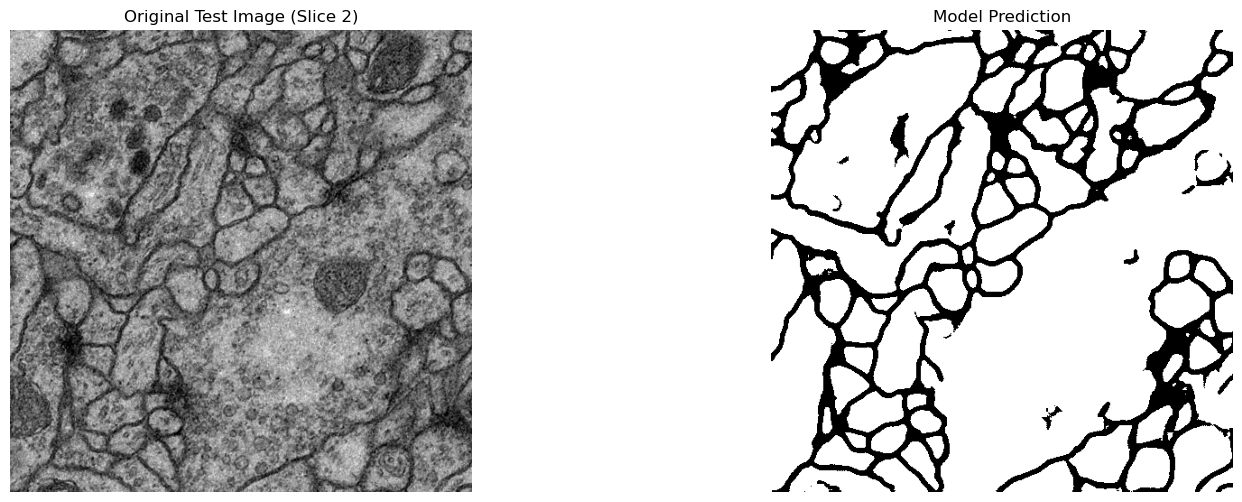

In [9]:
# --- Setup for Testing ---

# 1. Define the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load the trained model
# IMPORTANT: Change the fold number to test the model from a different fold.
# Let's load the model from the first fold as an example.
model_path = './models/unet_isbi_fold_2_best.pth' 

# Instantiate the model architecture
# This must match the architecture of the saved model
model_to_test = UNet(n_channels=1, n_classes=1).to(DEVICE)

# Load the saved weights
try:
    model_to_test.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {model_path}. Please check the path and fold number.")
    # Stop execution if model not found
    raise

# Set the model to evaluation mode (this is crucial!)
model_to_test.eval()

# 3. Load the test data
# This assumes your test data is in the root directory. Adjust path if needed.
try:
    test_images_raw = tifffile.imread('./data/test-volume.tif')   # Shape: (30, 512, 512)
except FileNotFoundError:
    print("ERROR: Test data ('test-volume.tif' or 'test-labels.tif') not found.")
    raise

# 4. Select a single image to test
# Let's pick an image from the middle of the stack
image_index_to_test = 2
test_image_slice = test_images_raw[image_index_to_test] # Shape: (512, 512), dtype: uint8

print(f"Testing on image slice: {image_index_to_test}")

# 5. Preprocess the test image using the *validation* transform
# The test data must be processed exactly like the validation data.
# `val_transform` was defined in a previous cell. It should just apply ToTensorV2.
if 'val_transform' not in locals():
    print("ERROR: `val_transform` is not defined. Please run the cell where augmentations are defined.")
    raise

# Apply the transform
transformed = val_transform(image=test_image_slice)
input_tensor = transformed['image'] # Shape: (1, 512, 512) for grayscale

# Add the batch dimension and send to device
# Final shape should be (1, 1, 512, 512)
input_tensor = input_tensor.unsqueeze(0).to(DEVICE, dtype=torch.float32)

# 6. Run inference
with torch.no_grad(): # Disable gradient calculations for inference
    pred_logits = model_to_test(input_tensor)

# 7. Post-process the output
# The output `pred_logits` is a tensor of raw scores.
# We need to apply sigmoid and a threshold to get a binary mask.
pred_probs = torch.sigmoid(pred_logits)
# Threshold at 0.5 to create the binary mask
pred_mask = (pred_probs > 0.5).float()

# Move the mask to the CPU and convert to a NumPy array for visualization
# Squeeze to remove the batch and channel dimensions (1, 1, 512, 512) -> (512, 512)
pred_mask_np = pred_mask.squeeze().cpu().numpy()

# 8. Visualize the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_image_slice, cmap='gray')
plt.title(f'Original Test Image (Slice {image_index_to_test})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_np, cmap='gray')
plt.title('Model Prediction')
plt.axis('off')

plt.show()